In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

### 추가
#plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
### 출처: https://giveme-happyending.tistory.com/192 [소연의_개발일지:티스토리]

import seaborn as sns

# utils
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

import seaborn as sns
from tqdm import tqdm
import pickle
# import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# import xgboost as xgb
# import lightgbm as lgb


# import eli5
# from eli5.sklearn import PermutationImportance
pd.set_option('display.max_columns', None)  # 모든 컬럼을 표시
pd.set_option('display.width', 800)        # 출력 창의 너비 설정

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
bus_feature = pd.read_csv('../data/bus_feature.csv')
sample_submission  = pd.read_csv('../data/sample_submission.csv')
subway_feature  = pd.read_csv('../data/subway_feature.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
print(f"train_shape: {train.shape}")
print(f"test_shape: {test.shape}")

train_shape: (1118822, 52)
test_shape: (9272, 51)


In [4]:
train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])

In [5]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적', 'k-전용면적별세대현황(60㎡이하)':'60m이하', 'k-전용면적별세대현황(60㎡~85㎡이하)':'85m이하', 'k-85㎡~135㎡이하':'135m이하', 'k-135㎡초과':'135m초과'})
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

Matplotlib is building the font cache; this may take a moment.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


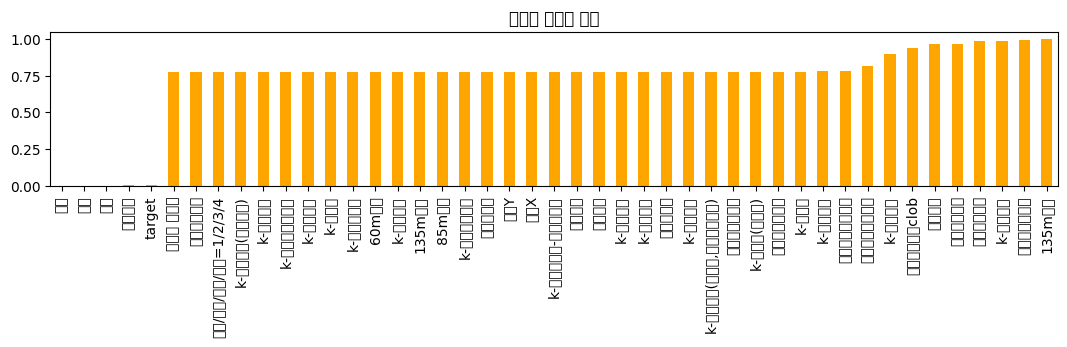

In [6]:
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [7]:
columns_to_drop = list(['시군구', '아파트명', '전용면적', '계약년월', '건축년도', '도로명', 'target', 'is_test'])

In [8]:
concat_select = concat[columns_to_drop]

In [9]:
concat_select.head(1)

,시군구,아파트명,전용면적,계약년월,건축년도,도로명,target,is_test
0,서울특별시 강남구 개포동,개포6차우성,79.97,201712,1987,언주로 3,124000.0,0


In [10]:
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [11]:
df = pd.DataFrame()
char_to_remove = '동'

# 열의 각 문자열에서 'o'가 포함되어 있으면 'o'를 제거하고, 그렇지 않으면 그대로 사용
df['test'] = concat_select['동'].apply(lambda x: x.replace(char_to_remove, '') if char_to_remove in x else x)


In [12]:
df['아파트'] = concat_select['아파트명']
df['test'] = df['test'].astype(str).fillna('')
df['아파트'] = df['아파트'].astype(str).fillna('')

In [13]:
import re
def remove_patterns_and_test(row):
    # 여러 패턴을 정의
    patterns = r'~|,|[A-Z]동|\d+차|\d+단지|\d+호|\d+동|\d'
    # 패턴 제거
    text = re.sub(patterns, '', row['아파트'])
    # 'test' 열의 문자열과 'test' + '동' 패턴 제거
    test_pattern = re.escape(row['test'])
    combined_pattern = fr'{test_pattern}동|{test_pattern}'
    text = re.sub(combined_pattern, '', text)
    return text.strip()
df['아파트'] = df.apply(remove_patterns_and_test, axis=1)

In [14]:
value_counts = df['아파트'].value_counts()

# 모든 값을 출력
pd.set_option('display.max_rows', len(value_counts))
print(value_counts)

아파트
주공                71623
현대                44195
우성                23289
신동아               14663
한신                14283
삼성래미안             13852
시영                12602
래미안               11819
두산                11116
벽산                10099
대림                 9697
삼성                 9250
목동신시가지             8743
                   8512
푸르지오               8407
한양                 8340
쌍용                 8173
신시가지               6926
건영                 6906
뉴타운                6616
성원                 6586
현대홈타운              6481
극동                 6342
동아                 6014
삼익                 5996
중앙하이츠              5702
청구                 5659
아이파크               5242
대우                 5151
대림e-편한세상           5110
신반포                4931
미성                 4846
그린                 4844
장미                 4619
힐스테이트              4542
경남아너스빌             4534
자이                 4481
파크리오               4372
동부센트레빌             4199
에스케이북한산시티          4049
경남                 3845
삼호          

In [15]:
# 문자 사이에 있는 숫자를 제거하는 함수 정의
def remove_digits_between_letters(text):
    # 문자 사이의 숫자를 찾아서 제거하는 정규 표현식 패턴
    pattern = r'(?<=[가-힣a-zA-Z])\d+(?=[가-힣a-zA-Z])'
    return re.sub(pattern, '', text)

# '로' 또는 '길'로 끝나는 패턴을 추출하는 함수 정의
def extract_road_name(text):
    # '로'로 끝나는 패턴을 먼저 추출
    match = re.search(r'.*?로', text)
    if not match:
        # '로'가 없으면 '길'로 끝나는 패턴을 추출
        match = re.search(r'.*?길', text)
    return match.group(0) if match else text

# '도로명' 열의 문자열을 변환하는 함수 정의
def transform_road_name(text):
    # 문자 사이의 숫자를 제거
    text = remove_digits_between_letters(text)
    # '로' 또는 '길'로 끝나는 부분만 남기기
    text = extract_road_name(text)
    return text

# '도로명' 열의 문자열을 변환
df['도로명'] = concat_select['도로명'].apply(transform_road_name)

In [16]:
concat_select['아파트'] = df['아파트']
concat_select['도로'] = df['도로명']

In [17]:
concat_select['건축년도_10년단위'] = pd.cut(concat_select['건축년도'], bins=range(1950, 2031, 10), right=False, labels=['1950','1960','1970','1980', '1990', '2000', '2010', '2020'])

In [18]:
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

In [22]:
dt_train.dtypes

아파트명            object
전용면적           float64
건축년도             int64
도로명             object
target         float64
is_test          int64
구               object
동               object
계약년             object
계약월             object
아파트             object
도로              object
건축년도_10년단위    category
dtype: object

In [20]:
# 아파트 기준 여러 EDA
apt_grouped = dt_train.groupby('아파트').sum()
apt_grouped['면적단가'] = apt_grouped['target'] / apt_grouped['전용면적']

TypeError: category type does not support sum operations

In [ ]:
apt_grouped.head()

In [ ]:
top_10 = apt_grouped.sort_values(by='면적단가', ascending=False).head(10)


In [ ]:
top_10

In [ ]:
dt_train

In [ ]:
# 구 지역별
gu_grouped = dt_train.groupby('구').agg({
    '전용면적': 'sum',
    'target': ['sum', 'mean']
})

# 컬럼 이름 정리
gu_grouped.columns = ['전용면적_합', '타겟_합', '타겟_평균(구)']

In [ ]:
gu_grouped['타겟_면적당_비율(구)'] = gu_grouped['타겟_합'] / gu_grouped['전용면적_합']


브레이크

In [ ]:
gu_grouped.head()

In [ ]:
# 동 지역별
dong_grouped = dt_train.groupby('동').agg({
    '전용면적': 'sum',
    'target': ['sum', 'mean']
})

# 컬럼 이름 정리
dong_grouped.columns = ['전용면적_합', '타겟_합(동)', '타겟_평균(동)']

In [ ]:
dong_grouped['타겟_면적당_비율(동)'] = dong_grouped['타겟_합(동)'] / dong_grouped['전용면적_합']


In [ ]:
dong_grouped.head()

In [ ]:
# 건축 연도별
gun_grouped = dt_train.groupby('건축년도_10년단위').agg({
    '전용면적': 'sum',
    'target': ['sum', 'mean']
})

# 컬럼 이름 정리
gun_grouped.columns = ['전용면적_합', '타겟_합(건)', '타겟_평균(건)']

In [ ]:
gun_grouped['타겟_면적당_비율(건)'] = gun_grouped['타겟_합(건)'] / gun_grouped['전용면적_합']


In [ ]:
gun_grouped

In [ ]:
gun_grouped.reset_index(inplace=True)

In [ ]:
merge_g = gun_grouped[['건축년도_10년단위','타겟_평균(건)','타겟_면적당_비율(건)']]
merged_df = pd.merge(concat_select, merge_g, on='건축년도_10년단위', how='left')

In [ ]:
dong_grouped.reset_index(inplace=True)

In [ ]:
merge_d = dong_grouped[['동','타겟_평균(동)','타겟_면적당_비율(동)']]
merged_df = pd.merge(merged_df, merge_d, on='동', how='left')

In [ ]:
gu_grouped.reset_index(inplace=True)

In [ ]:
merge_gu = gu_grouped[['구','타겟_평균(구)','타겟_면적당_비율(구)']]
merged_df = pd.merge(merged_df, merge_gu, on='구', how='left')

In [ ]:
merged_df.head(1)

In [ ]:
na_mask=merged_df.isna().sum()
na_rows = merged_df[merged_df.isna().any(axis=1)]

print(na_rows)

In [ ]:
dt_train = merged_df.query('is_test==0')
dt_test = merged_df.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

In [ ]:
dt_test['target'] = 0

In [ ]:
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in merged_df.columns:
    if pd.api.types.is_numeric_dtype(merged_df[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

In [ ]:
for col in categorical_columns_v2:
    dt_train[col] = dt_train[col].astype(str).fillna('')
    dt_test[col] = dt_test[col].astype(str).fillna('')

In [ ]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

In [ ]:
dt_train.value_counts()

In [ ]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [ ]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=500, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

In [ ]:
pred = model.predict(X_train)

In [ ]:
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_train, pred))}')

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

In [ ]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output07_16_500.csv', index=False)

In [ ]:
y_train = np.log1p(dt_train['target'])
X_train = dt_train.drop(['target'], axis=1)

In [ ]:
import xgboost

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective": "reg:squarederror",  # 회귀 문제로 설정
    "eval_metric": "rmse"
    ,"eta"              : 0.2
    ,"max_depth"        : 4
    ,"min_child_weight" :8
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
    ,"device"           :"cuda"
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=1500000, evals=watchlist, verbose_eval=1000)
xgboost.plot_importance(bst)